In [1]:
!pip install kaggle
!kaggle datasets download -d msambare/fer2013
!unzip fer2013.zip -d dataset


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open fer2013.zip, fer2013.zip.zip or fer2013.zip.ZIP.


In [2]:
!pip install icrawler

In [3]:
from icrawler.builtin import GoogleImageCrawler
import os

def download_images(keyword, max_num, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    crawler = GoogleImageCrawler(storage={'root_dir': save_dir})
    crawler.crawl(
        keyword=keyword,
        max_num=max_num,
        filters={'size': 'large'},  # larger images for better training
    )

# Download for each emotion
download_images("happy face person", 2000, "dataset/happy")
download_images("sad face person", 2000, "dataset/sad")
download_images("angry face person", 2000, "dataset/angry")
download_images("surprised face person", 2000, "dataset/surprised")


ERROR:downloader:Response status code 404, file https://as1.ftcdn.net/jpg
ERROR:downloader:Response status code 404, file https://as2.ftcdn.net/jpg
ERROR:downloader:Response status code 403, file https://static.vecteezy.com/system/resources/previews/006/914/560/large_2x/image-of-indian-boy-happy-face-image-photo.jpg
ERROR:downloader:Response status code 403, file https://static.vecteezy.com/system/resources/previews/047/721/312/non_2x/smiling-happy-face-personality-character-human-person-mascot-cartoon-flat-icon-vector.jpg
ERROR:downloader:Exception caught when downloading file https://get.pxhere.com/photo/person-girl-hair-summer-portrait-child-facial-expression-lip-hairstyle-smile-laugh-mouth-close-up-human-body-face-family-nose-children-happy-infant-toddler-eye-head-skin-joy-blond-organ-laughter-tooth-sweetness-emotion-small-child-portrait-photography-588457.jpg, error: HTTPSConnectionPool(host='get.pxhere.com', port=443): Read timed out. (read timeout=5), remaining retry times: 2
ER

In [4]:
rotation_range=30
width_shift_range=0.2
height_shift_range=0.2
zoom_range=0.2
horizontal_flip=True
brightness_range=[0.8,1.2]


In [7]:
# =============================================
# 1️⃣ Install and import necessary libraries
# =============================================
!pip install tensorflow matplotlib

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# =============================================
# 2️⃣ Data Preparation with Augmentation
# =============================================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # split 20% for validation
)

train_generator = train_datagen.flow_from_directory(
    'dataset',  # replace with your dataset path
    target_size=(128,128),
    batch_size=8,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    'dataset',
    target_size=(128,128),
    batch_size=8,
    class_mode='categorical',
    subset='validation'
)

# =============================================
# 3️⃣ Build the model using MobileNetV2
# =============================================
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base layers initially
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# =============================================
# 4️⃣ Train the last dense layers first
# =============================================
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15
)

# =============================================
# 5️⃣ Fine-tune some of the base layers
# =============================================
for layer in base_model.layers[-20:]:  # last 20 layers
    layer.trainable = True

model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

# =============================================
# 6️⃣ Test on known dataset images
# =============================================
class_map = {v:k for k,v in train_generator.class_indices.items()}
for emotion in ['happy','sad','angry','surprised']:
    img_path = f'dataset/{emotion}/000001.jpg'
    img = Image.open(img_path).convert('RGB').resize((128,128))
    img_array = np.expand_dims(np.array(img)/255.0, axis=0)
    pred_idx = np.argmax(model.predict(img_array))
    print(f"True: {emotion}, Predicted: {class_map[pred_idx]}")

# =============================================
# 7️⃣ Single-shot webcam prediction (no OpenCV)
# =============================================
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import io



Found 167 images belonging to 4 classes.
Found 40 images belonging to 4 classes.
Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 669ms/step - accuracy: 0.2071 - loss: 2.2174 - val_accuracy: 0.2000 - val_loss: 1.3908
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 575ms/step - accuracy: 0.2594 - loss: 1.7329 - val_accuracy: 0.3750 - val_loss: 1.4188
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 565ms/step - accuracy: 0.2730 - loss: 1.7146 - val_accuracy: 0.3250 - val_loss: 1.3928
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 581ms/step - accuracy: 0.3086 - loss: 1.4675 - val_accuracy: 0.3500 - val_loss: 1.3340
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 561ms/step - accuracy: 0.4309 - loss: 1.4129 - val_accuracy: 0.2750 - val_loss: 1.3828
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 541ms/step - accuracy: 0.4510 - loss: 1.2769 - val_accuracy: 0.2750 - val_loss: 1.3423
Epoch 7/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 570ms/step - accuracy: 0.3759 - loss: 1.3239 - val_accuracy: 0.2750 - val_loss: 1.3956
Epoch 8/15
21/21

In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(input_shape=(128,128,3), include_top=False, weights='imagenet')
base_model.trainable = False  # freeze base layers

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax')   # 4 emotions
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [10]:
from google.colab.output import eval_js
from PIL import Image
import io
import numpy as np
from base64 import b64decode

# Plain JS string
js_code = """
async function capture() {
  const video = document.createElement('video');
  document.body.appendChild(video);
  const stream = await navigator.mediaDevices.getUserMedia({video:true});
  video.srcObject = stream;
  await video.play();
  const canvas = document.createElement('canvas');
  canvas.width = video.videoWidth;
  canvas.height = video.videoHeight;
  canvas.getContext('2d').drawImage(video, 0, 0);
  stream.getTracks().forEach(track => track.stop());
  video.remove();
  return canvas.toDataURL('image/jpeg', 0.8);
}
capture();
"""

# Step 2: eval_js returns a string (base64), not a JS object
data_url = eval_js(js_code)

# Step 3: convert base64 to image
encoded = data_url.split(',')[1]
img_bytes = b64decode(encoded)
img = Image.open(io.BytesIO(img_bytes)).convert('RGB')

# Step 4: convert to NumPy array for model
frame = np.array(img)
print("Captured frame shape:", frame.shape)


Captured frame shape: (480, 640, 3)


In [11]:
from sklearn.metrics import classification_report

y_true = []
y_pred = []

for X, y in val_generator:
    preds = model.predict(X)
    y_true.extend(y.argmax(axis=1))
    y_pred.extend(preds.argmax(axis=1))
    if len(y_true) >= val_generator.samples:
        break

print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        12
       happy       0.24      1.00      0.39         9
         sad       0.00      0.00      0.00        10
   surprised       0.00      0.00      0.00         9

    accuracy                           0.23        40
   macro avg       0.06      0.25      0.10        40
weighted avg       0.05      0.23      0.09        40



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
from PIL import Image
import numpy as np

img_resized = Image.fromarray(frame).resize((128,128))
img_array = np.array(img_resized) / 255.0   # normalize to [0,1]
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension


In [13]:
pred_idx = np.argmax(model.predict(img_array))
class_map = {v: k for k, v in train_generator.class_indices.items()}  # index → label
predicted_emotion = class_map[pred_idx]

print("Predicted emotion:", predicted_emotion)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted emotion: happy


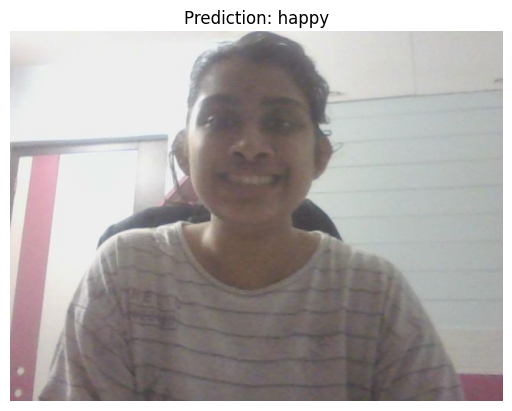

In [14]:
import matplotlib.pyplot as plt

plt.imshow(frame)
plt.title("Prediction: " + predicted_emotion)
plt.axis('off')
plt.show()
